    Arun Das
    Research Fellow
    Secure AI and Autonomy Laboratory
    University of Texas at San Antonio

# The 'Capsule' invariance problem

> A capsule is a group of neurons whose activity vector represents the instantiation
parameters of a specific type of entity such as an object or an object part. We use
the length of the activity vector to represent the probability that the entity exists and
its orientation to represent the instantiation parameters. Active capsules at one level
make predictions, via transformation matrices, for the instantiation parameters of
higher-level capsules. When multiple predictions agree, a higher level capsule
becomes active. We show that a discrimininatively trained, multi-layer capsule
system achieves state-of-the-art performance on MNIST and is considerably better
than a convolutional net at recognizing highly overlapping digits. To achieve these
results we use an iterative routing-by-agreement mechanism: A lower-level capsule
prefers to send its output to higher level capsules whose activity vectors have a big
scalar product with the prediction coming from the lower-level capsule.

![capsulenet](./images/capsulenetwork.png "Capsule Network Architecture")

![capsulenet](./images/capsulenet-reconstruction.png "Capsule Network Reconstruction Arch")

## Tasks

- [x] Get capsule working
- [x] Study normal behavior on MNIST
- [x] Study scaling invariance behavior
- [x] Study rotation invariance behavior
- [ ] Retrain on AffineMNIST ?

## Results

![capsulenet](./images/capsule_rotation_study.png "Capsule rotation invariance study (0-360) degrees")

![capsulenet](./images/capsule_scaling_study.png "Capsule scale invariance study (10-300) %")

## Load packages and define hyper parameters

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
from torchvision.utils import make_grid
import math
import pandas as pd
from PIL import Image
#from skimage.transform.radon_transform import fft
from scipy import fftpack
from torchvision.datasets.mnist import MNIST

from torch.autograd import Variable
from torch.optim import Adam
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger
from torchvision.utils import make_grid
from torchvision.datasets.mnist import MNIST
from tqdm import tqdm
import torchnet as tnt


#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

In [8]:
BATCH_SIZE = 300
NUM_CLASSES = 10
NUM_EPOCHS = 20
NUM_ROUTING_ITERATIONS = 3

In [9]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)


def augmentation(x, max_shift=2):
    _, _, height, width = x.size()

    h_shift, w_shift = np.random.randint(-max_shift, max_shift + 1, size=2)
    source_height_slice = slice(max(0, h_shift), h_shift + height)
    source_width_slice = slice(max(0, w_shift), w_shift + width)
    target_height_slice = slice(max(0, -h_shift), -h_shift + height)
    target_width_slice = slice(max(0, -w_shift), -w_shift + width)

    shifted_image = torch.zeros(*x.size())
    shifted_image[:, :, source_height_slice, source_width_slice] = x[:, :, target_height_slice, target_width_slice]
    return shifted_image.float()


class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations=NUM_ROUTING_ITERATIONS):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(*priors.size())).cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)

        return outputs


class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 6 * 6, in_channels=8,
                                           out_channels=16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1) #something wrong here which I have no clue about
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)

        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))

        return classes, reconstructions


class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        assert torch.numel(images) == torch.numel(reconstructions)
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)
    
class CustomScaling(object):
    """Rotate image by a fixed angle which is ready for tranform.Compose()
    """

    def __init__(self, scale, angle=0, translate=[0,0], shear=0):
        self.scale = scale
        self.angle = angle
        self.translate = translate
        self.shear = shear

    def __call__(self, img):
        
        return transforms.ToTensor()(
            transforms.functional.affine(
                transforms.ToPILImage()(img), 
                self.angle, self.translate, self.scale, self.shear))

class CustomRotation(object):
    """Rotate image by a fixed angle which is ready for tranform.Compose()
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        self.degrees = degrees
        self.resample = resample
        self.expand = expand
        self.center = center

    def __call__(self, img):
        
        return transforms.ToTensor()(
            transforms.functional.rotate(
                transforms.ToPILImage()(img), 
                self.degrees, self.resample, self.expand, self.center))
    
def rotate_tensor(_in_tensor, plot=True):
    """
    Usage: number, number_90, number_180, number_270 = rotate_tensor(example_data[15])
    """
    in_tensor = _in_tensor.clone()
    # Add one more channel to the beginning. Tensor shape = 1,1,28,28
    in_tensor.unsqueeze_(0)
    # Convert to Pytorch variable
    in_tensor = Variable(in_tensor, requires_grad=True)
    
    in_tensor_90 = in_tensor.transpose(2, 3).flip(3)
    in_tensor_180 = in_tensor.flip(2).flip(3)
    in_tensor_270 = in_tensor.transpose(2, 3).flip(2)
    
    if plot:
        plt.figure(1)
        plt.subplot(221)
        plt.gca().set_title('0 degree')
        plt.imshow(in_tensor[0][0].cpu().detach().clone(), cmap='gray')
        plt.subplot(222)
        plt.gca().set_title('+90 degree')
        plt.imshow(in_tensor_90[0][0].cpu().detach().clone(), cmap='gray')
        plt.subplot(223)
        plt.gca().set_title('+270 degree')
        plt.imshow(in_tensor_270[0][0].cpu().detach().clone(), cmap='gray')
        plt.subplot(224)
        plt.gca().set_title('+180 degree')
        plt.imshow(in_tensor_180[0][0].cpu().detach().clone(), cmap='gray')
        plt.tight_layout()
        plt.show()
    return(in_tensor, in_tensor_90, in_tensor_180, in_tensor_270)

def custom_viz(kernels, path=None, cols=None, size=None, verbose=False, axis=False):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]
    total_cols = N*C
    pos = range(1,total_cols + 1)
    
    if verbose:
        print("Shape of input: ", kernels.shape)
        
    if cols==None:
        req_cols = C
        num_rows = N
    elif cols:
        req_cols = cols
        # Account for more rows while diving total cols
        # with requested number of cols in the figure
        # Hence, using np.ceil to get the largest int
        # from the quotient of division.
        num_rows = int(np.ceil(total_cols/req_cols))
    elif C>1:
        # Check for 1D arrays and such. Mostly not needed.
        req_cols = C

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            ax.imshow(img, cmap='gray')
            if axis:
                plt.axis('on')
            elif axis==False:
                plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()

def clean_up_variable(starts_with=None):
    for name in dir():
        if name.startswith(str(starts_with)):
            del globals()[name]

    for name in dir():
        if name.startswith(str(starts_with)):
            del locals()[name]
#     except TypeError:
#         print("ERR: Please pass first few letters of the variables you need to delete as an argument")
        
def test_capsulenet(_model, _test_loader):
    """
    Evaluate the test performance of capsulenet
    """
    acc = 0
    for batch_idx, (ground_truth, example_targets) in enumerate(_test_loader):
        output_label, _ = _model(Variable(ground_truth).cuda())
        equality = (example_targets == torch.exp(output_label).max(dim=1)[1].cpu())
        # print(equality)
        acc += equality.type(torch.FloatTensor).mean()
    return acc/float(batch_idx+1)

In [10]:
model = CapsuleNet()
model.load_state_dict(torch.load('epochs/epoch_21.pt'))
model.cuda()

print("# parameters:", sum(param.numel() for param in model.parameters()))

# parameters: 8215568


In [12]:
summary(model, (1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
            Conv2d-2             [-1, 32, 6, 6]         663,584
            Conv2d-3             [-1, 32, 6, 6]         663,584
            Conv2d-4             [-1, 32, 6, 6]         663,584
            Conv2d-5             [-1, 32, 6, 6]         663,584
            Conv2d-6             [-1, 32, 6, 6]         663,584
            Conv2d-7             [-1, 32, 6, 6]         663,584
            Conv2d-8             [-1, 32, 6, 6]         663,584
            Conv2d-9             [-1, 32, 6, 6]         663,584
     CapsuleLayer-10              [-1, 1152, 8]               0
     CapsuleLayer-11          [-1, 2, 1, 1, 16]               0
           Linear-12                  [-1, 512]          82,432
             ReLU-13                  [-1, 512]               0
           Linear-14                 [-

In [13]:
model.eval()

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (primary_capsules): CapsuleLayer(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): CapsuleLayer()
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [14]:
def get_iterator(mode):
    dataset = MNIST(root='./data', download=True, train=mode)
    data = getattr(dataset, 'train_data' if mode else 'data')
    labels = getattr(dataset, 'train_labels' if mode else 'targets')
    tensor_dataset = tnt.dataset.TensorDataset([data, labels])

    return tensor_dataset.parallel(batch_size=BATCH_SIZE, num_workers=4, shuffle=mode)

test_sample = next(iter(get_iterator(False)))

ground_truth = (test_sample[0].unsqueeze(1).float() / 255.0)
output_label, reconstructions = model(Variable(ground_truth).cuda())
reconstruction = reconstructions.cpu().view_as(ground_truth).data

Predicted Class:  2


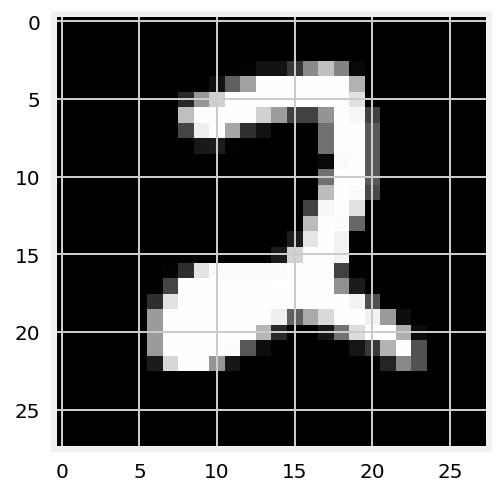

In [15]:
image_id = np.random.randint(100, size=1)[0]
print("Predicted Class: ", np.argmax(output_label[image_id].cpu().detach().numpy()))
plt.imshow(test_sample[0][image_id].unsqueeze(0).cuda().cpu().detach().numpy()[0], cmap='gray')
plt.show()

## Reconstruction as a regularization method

> We use an additional reconstruction loss to encourage the digit capsules to encode the instantiation
parameters of the input digit. During training, we mask out all but the activity vector of the correct
digit capsule. Then we use this activity vector to reconstruct the input image. The output of the digit
capsule is fed into a decoder consisting of 3 fully connected layers that model the pixel intensitie

# Bring our own train and test loader.

In [16]:
# default data loaders
orig_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

orig_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=False)

orig_examples = enumerate(orig_test_loader)
orig_batch_idx, (orig_ground_truth, orig_example_targets) = next(orig_examples)

orig_output_label, orig_reconstructions = model(Variable(orig_ground_truth).cuda())
orig_reconstruction = orig_reconstructions.cpu().view_as(orig_ground_truth).data

Actual Class:  7 || Predicted Class:  7


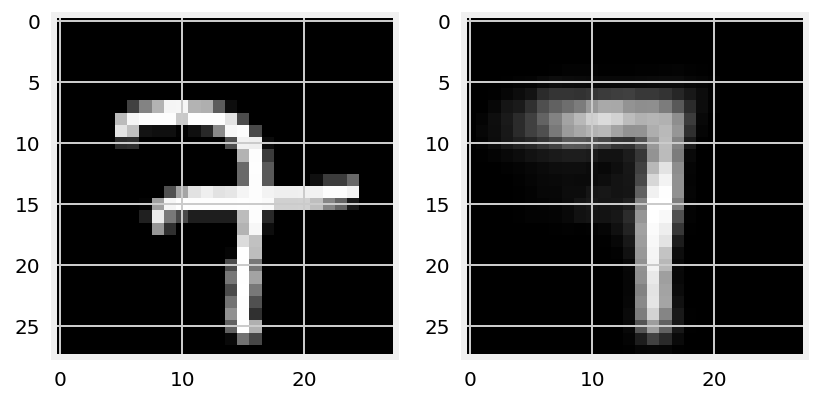

In [17]:
image_id = np.random.randint(BATCH_SIZE, size=1)[0]

print("Actual Class: ", int(orig_example_targets[image_id].cpu().detach().numpy()), "|| Predicted Class: ", np.argmax(orig_output_label[image_id].cpu().detach().numpy()))

fig = plt.figure()
plt.subplot(121)
plt.imshow(orig_ground_truth[image_id].cuda().cpu().detach().numpy()[0], cmap='gray')
plt.subplot(122)
plt.imshow(orig_reconstruction[image_id].cuda().cpu().detach().numpy()[0], cmap='gray')
plt.show()

In [ ]:
orig_acc = test_capsulenet(model, orig_test_loader)
print("Test Accuracy for original images is: ", orig_acc.cpu().detach().numpy())

In [ ]:
clean_up_variable('orig')
# %who_ls

# Scaling Test ??

In [ ]:
scale = 0.9 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomScaling function to the transformations
scale_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

scale_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                   ])),
    batch_size=BATCH_SIZE, shuffle=False)

scale_examples = enumerate(scale_test_loader)
scale_batch_idx, (scale_ground_truth, scale_example_targets) = next(scale_examples)

# ground_truth = (test_sample[0].unsqueeze(1).float() / 255.0)
scale_output_label, scale_reconstructions = model(Variable(scale_ground_truth).cuda())
scale_reconstruction = scale_reconstructions.cpu().view_as(scale_ground_truth).data
scale_acc = test_capsulenet(model, scale_test_loader)

print("Test Accuracy for %d percent scaled images is: %.4f" %(scale*100, scale_acc.cpu().detach().numpy()))

In [ ]:
image_id = np.random.randint(BATCH_SIZE, size=1)[0]

print("Actual Class: ", int(scale_example_targets[image_id].cpu().detach().numpy()), "|| Predicted Class: ", np.argmax(scale_output_label[image_id].cpu().detach().numpy()))

fig = plt.figure()
plt.subplot(121)
plt.imshow(scale_ground_truth[image_id].cuda().cpu().detach().numpy()[0], cmap='gray')
plt.subplot(122)
plt.imshow(scale_reconstruction[image_id].cuda().cpu().detach().numpy()[0], cmap='gray')
plt.show()

### LOOP FOR EASY STUDY

In [ ]:
scale_acc_study = []
scales = np.arange(0.1, 3.1, 0.1)

for i in scales:
    scale = round(i,2) # Specifies the scaling factor of images.

    # Define the train and test loader
    # Here we are adding our CustomScaling function to the transformations
    scale_train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           CustomScaling(scale),
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

    scale_test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           CustomScaling(scale),
                       ])),
        batch_size=BATCH_SIZE, shuffle=False)

    scale_examples = enumerate(scale_test_loader)
    scale_batch_idx, (scale_ground_truth, scale_example_targets) = next(scale_examples)

    # ground_truth = (test_sample[0].unsqueeze(1).float() / 255.0)
    scale_output_label, scale_reconstructions = model(Variable(scale_ground_truth).cuda())
    scale_reconstruction = scale_reconstructions.cpu().view_as(scale_ground_truth).data
    scale_acc = test_capsulenet(model, scale_test_loader)
    scale_acc_study.append(scale_acc)
    print("Test Accuracy for %d percent scaled images is: %.4f" %(scale*100, scale_acc.cpu().detach().numpy()))
np.savetxt(fname="capsule_scaling_acc_values.txt", X=scale_acc_study)

In [ ]:
# Plot for variation in scales
plt.plot(scales, scale_acc_study)
plt.xlabel('Scale', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
plt.suptitle("Capsule Scaling Study - Scales (10 - 300)")
plt.savefig('images/capsule_scaling_study.png', dpi=200)
plt.show()

### LOOP ENDS

In [ ]:
for name in dir():
    if name.startswith('rota'):
        del globals()[name]
for name in dir():
    if name.startswith('Custom'):
        del globals()[name]
%who_ls

In [ ]:
clean_up_variable('scale')
%who_ls

# Rotation Test ??

In [ ]:
rotation = 20 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomRotation(rotation),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomRotation(rotation),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=False)


## try out stuff

# transforms.functional.affine(img=transforms.functional.to_pil_image(example_data[0]),
#                              angle=0, translate=(0,0),
#                              scale=0.4, shear=0)


examples = enumerate(test_loader)
batch_idx, (ground_truth, example_targets) = next(examples)

# ground_truth = (test_sample[0].unsqueeze(1).float() / 255.0)
output_label, reconstructions = model(Variable(ground_truth).cuda())
reconstruction = reconstructions.cpu().view_as(ground_truth).data

In [5]:
rotation_acc_study = []
rotations = np.arange(0, 370, 10)

for rotation in rotations:
    # Define the train and test loader
    # Here we are adding our CustomRotation function to the transformations
    rotation_train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           CustomRotation(rotation),
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

    rotation_test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           CustomRotation(rotation),
                       ])),
        batch_size=BATCH_SIZE, shuffle=False)

    rotation_examples = enumerate(rotation_test_loader)
    rotation_batch_idx, (rotation_ground_truth, rotation_example_targets) = next(rotation_examples)

    # ground_truth = (test_sample[0].unsqueeze(1).float() / 255.0)
    rotation_output_label, rotation_reconstructions = model(Variable(rotation_ground_truth).cuda())
    rotation_reconstruction = rotation_reconstructions.cpu().view_as(rotation_ground_truth).data
    rotation_acc = test_capsulenet(model, rotation_test_loader)
    rotation_acc_study.append(rotation_acc)
    print("Test Accuracy for %d percent scaled images is: %.4f" %(rotation, rotation_acc.cpu().detach().numpy()))
np.savetxt(fname="capsule_rotation_acc_values.txt", X=rotation_acc_study)

Test Accuracy for 0 percent scaled images is: 0.9948
Test Accuracy for 10 percent scaled images is: 0.9882
Test Accuracy for 20 percent scaled images is: 0.9632
Test Accuracy for 30 percent scaled images is: 0.8810
Test Accuracy for 40 percent scaled images is: 0.7290
Test Accuracy for 50 percent scaled images is: 0.5219
Test Accuracy for 60 percent scaled images is: 0.3416
Test Accuracy for 70 percent scaled images is: 0.2352
Test Accuracy for 80 percent scaled images is: 0.1748
Test Accuracy for 90 percent scaled images is: 0.1572
Test Accuracy for 100 percent scaled images is: 0.1689
Test Accuracy for 110 percent scaled images is: 0.1891
Test Accuracy for 120 percent scaled images is: 0.2352
Test Accuracy for 130 percent scaled images is: 0.3017
Test Accuracy for 140 percent scaled images is: 0.3594
Test Accuracy for 150 percent scaled images is: 0.4088
Test Accuracy for 160 percent scaled images is: 0.4436
Test Accuracy for 170 percent scaled images is: 0.4650
Test Accuracy for 180

In [ ]:
# Plot for variation in scales
fig = plt.Figure()
plt.plot(rotations, rotation_acc_study)
plt.xlabel('Rotation', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
plt.suptitle("Capsule Rotation Study - Angles (0 -360)")
plt.savefig('images/capsule_rotation_study.png', dpi=200)
plt.show()